# Inverse Problems

## Blur + Noise reconstruction

Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import equinox as eqx
import jax 
import jax.scipy as jsp
import jax.numpy as jnp
import helper as hlp
from tqdm import tqdm
import optax 
from functools import partial
%matplotlib inline
%load_ext autoreload
%autoreload 2

Working images 

- Version 1: without periodic padding

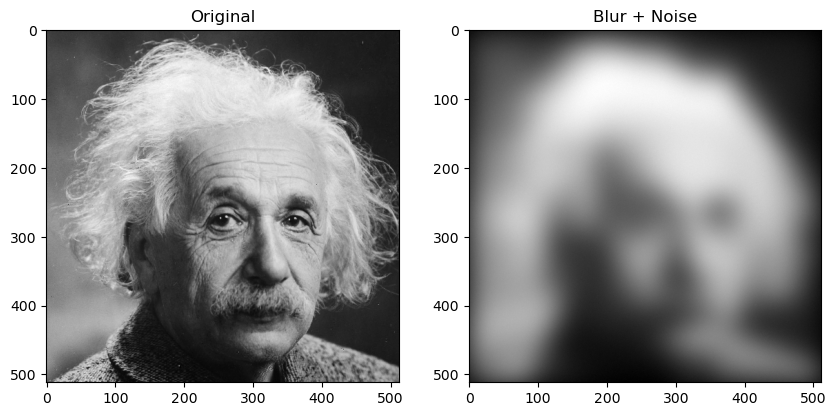

In [2]:
# original img 
img = ski.io.imread('data/img/einstein.tif').astype(np.float32)

# blurred and noisy img
gaussian_kernel = hlp.get_2D_Gaussian_kernel(20)
blur_img = jsp.signal.convolve(img,gaussian_kernel, mode='same')
np.random.seed(4)
gaussian_noise = np.random.normal(0, 1, img.shape)
blur_noise_img = blur_img + gaussian_noise
blur_noise_img= np.clip(blur_noise_img, 0,255)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10,10))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
plt.show()

- Version 2: with periodic padding

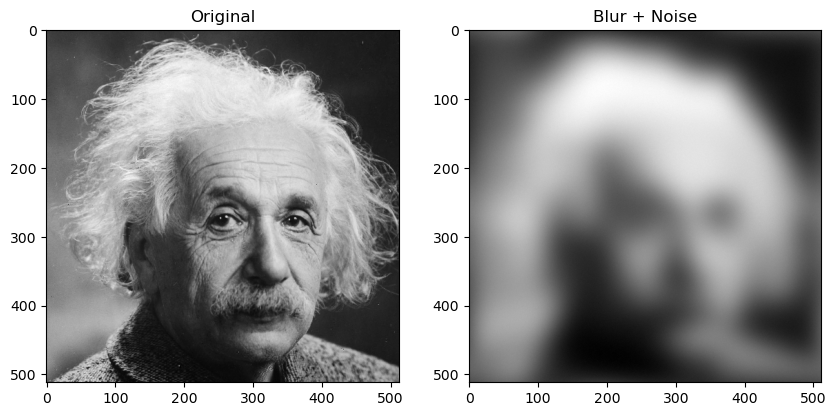

In [2]:
# original img 
img = ski.io.imread('data/img/einstein.tif').astype(np.float32)

# blurred and noisy img
gaussian_kernel = hlp.get_2D_Gaussian_kernel(20)

# perform convolution in Fourrier space by considering periodic padding
img_kernel = hlp.kernel_to_image(gaussian_kernel, img )
img_kernel_f = jnp.fft.fft2(img_kernel)
img_f = jnp.fft.fft2(img) 
per_blur_img_f = jnp.multiply(img_kernel_f, img_f)

# go back into space domain
per_blur_img = jnp.fft.ifft2(per_blur_img_f).real

# add noise
np.random.seed(4)
gaussian_noise = np.random.normal(0, 1, img.shape)
per_blur_noise_img = per_blur_img + gaussian_noise
per_blur_noise_img= np.clip(per_blur_noise_img, 0,255)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10,10))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
plt.show()

Reconstruction

- model 1: corresponding to version 1 without padding

In [3]:
class Model(eqx.Module):
    kernel: jnp.ndarray
    # y: jnp.ndarray

    def __init__(self, kernel):
        self.kernel = kernel
        # self.y = y

    def __call__(self, x):
        Ax = jsp.signal.convolve(x,self.kernel, mode='same') # this convolution doesn't have periodic condition boundary (for the convolution)
        return Ax
    

# loss function 
def loss(x, y, A): 
    loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return loss

# optimizer --> GD
# @jax.jit  
@partial(jax.jit,  static_argnames=['loss'])
def optimizer_step(x, y, A, alpha, loss):  # alpha = learning rate
    loss_val, grads_val = jax.value_and_grad(loss)(x, y, A)
    # print(grads_val)
    
    # GD update
    x_new = x - alpha * grads_val

    # projection
    x_new = jnp.clip(x_new, 0, 255)

    return loss_val, x_new





In [ ]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))


# optimization parameters
alpha = 0.5
n_iter = 200 


losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha, loss) 
    losses.append(loss_val)

100%|██████████| 200/200 [04:53<00:00,  1.47s/it]


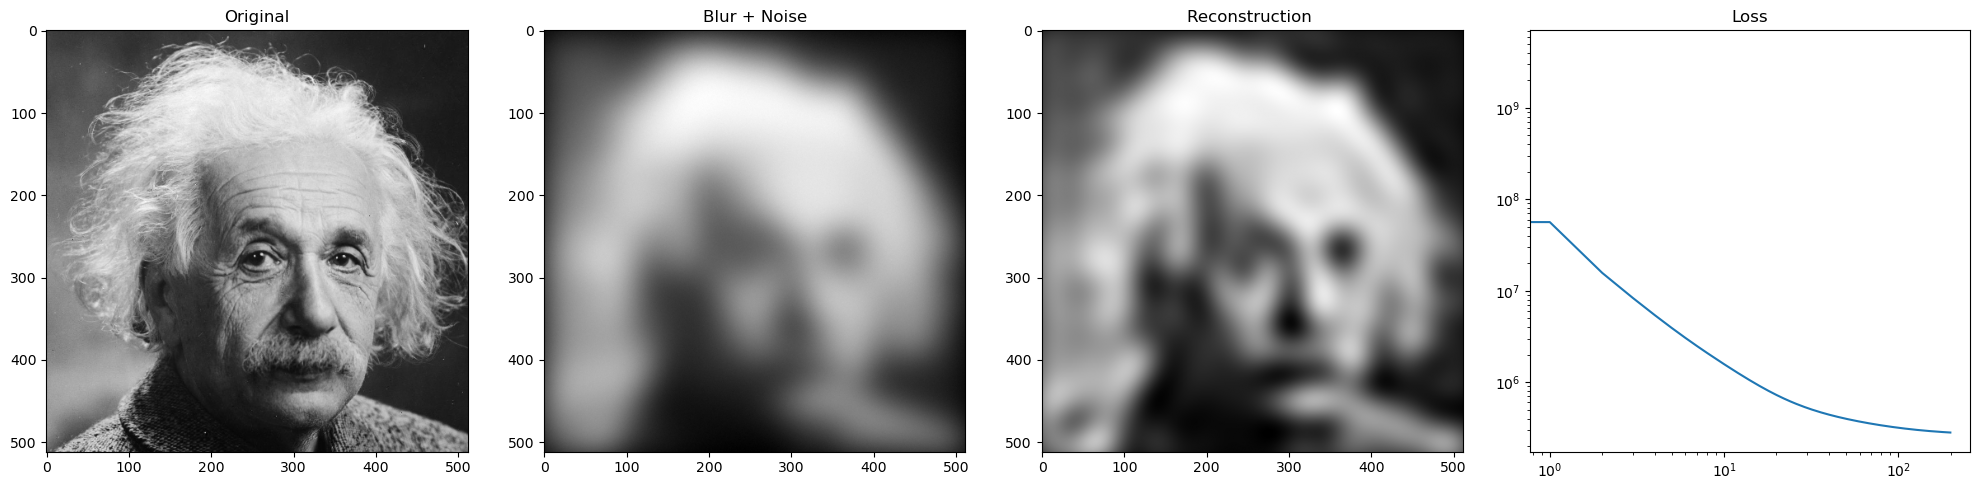

In [57]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

with ADAM optimizer (still version 1 ie. without periodic padding)

In [ ]:
# optimization parameters
alpha = 7
n_iter = 300


# optimizer --> ADAM
ADAM_optimizer = optax.adam(learning_rate=alpha)


def adam_optimizer_step(x, opt_state, loss):
    loss_val, grads_val = jax.value_and_grad(loss)(x, y, A)
    
    # ADAM update
    updates, opt_state = ADAM_optimizer.update(grads_val, opt_state)
    x = optax.apply_updates(x, updates)

    # projection
    # x_new = jnp.clip(x_new, 0, 255)

    return x, opt_state, loss_val


# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))
opt_state = ADAM_optimizer.init(x)

losses = []
# solve 
for _ in tqdm(range(n_iter)):
    x, opt_state, loss_val  = adam_optimizer_step(x, opt_state, loss) 
    losses.append(loss_val)

100%|██████████| 300/300 [08:40<00:00,  1.73s/it]


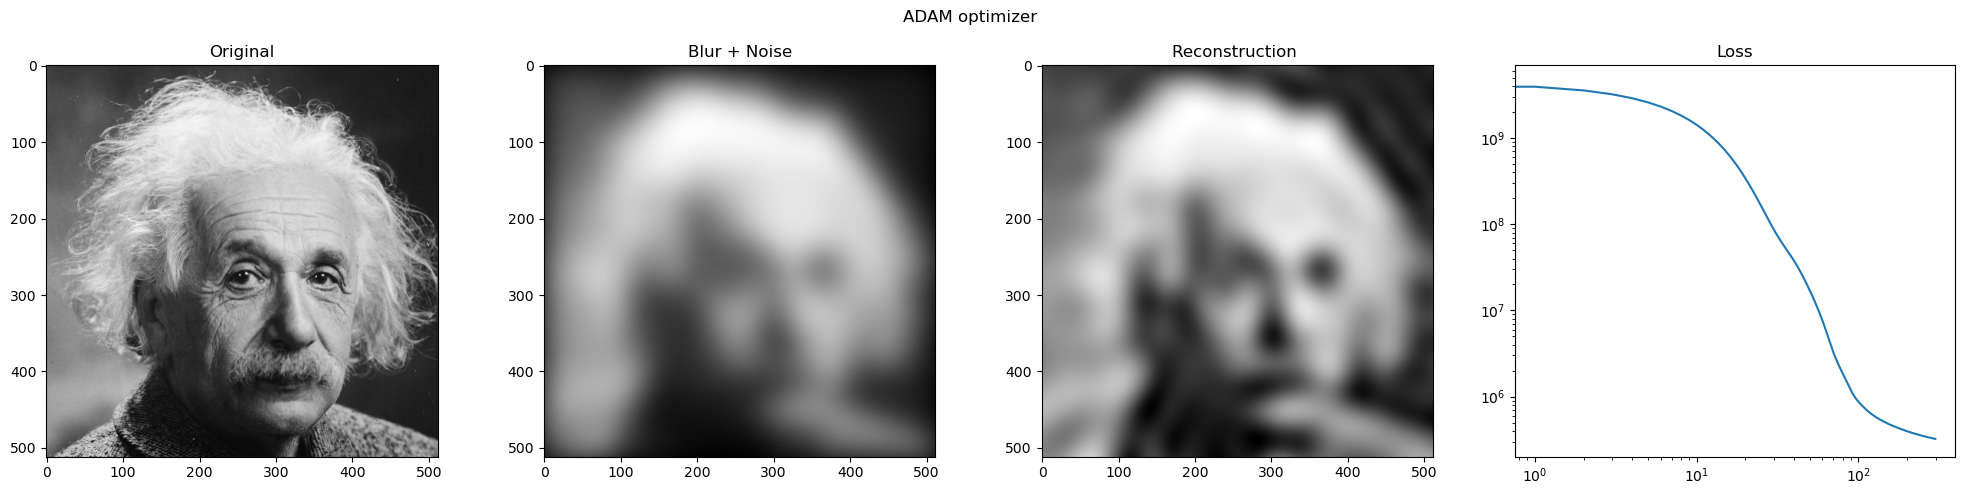

In [71]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('ADAM optimizer')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

- model 2: corresponding to version 2 with periodic padding

In [3]:
class Model_periodic_padding(eqx.Module):
    img_kernel_f: jnp.ndarray

    def __init__(self, img_kernel):
        self.img_kernel_f = jnp.fft.fft2(img_kernel)

    def __call__(self, x):
        # dft
        x_f = jnp.fft.fft2(x) 

        # filtering
        Ax_f = jnp.multiply(self.img_kernel_f, x_f)

        # go back into space domain
        Ax = jnp.fft.ifft2(Ax_f).real

        return Ax
    # loss and optimzer_step functions remain the same 

In [ ]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(per_blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
L = jnp.max(jnp.abs(A.img_kernel_f))


# optimization parameters
alpha = 1/L
n_iter = 40000 
# n_iter = 10 



losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha, loss) 
    losses.append(loss_val)

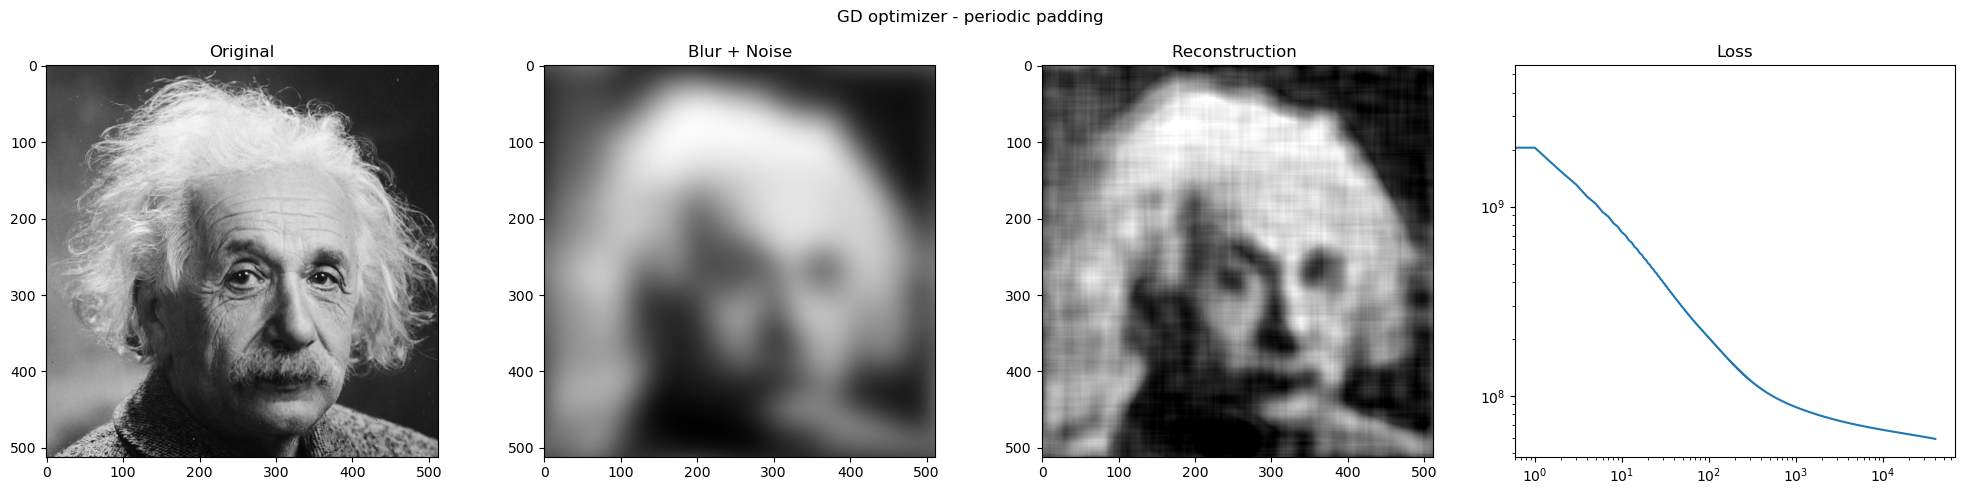

In [ ]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('GD optimizer - periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

### With regulizer 

- L2: \norm{x}{2}^{2} model 1 (without periodic padding)

In [6]:
# objectiv function : F(x) = f(x) + g(x)
# the problem can be written as argmin{f(x) + g(x)} where f(x) = ||y-Ax||{2}^{2} and g(x) = ||x||{2}^{2}
# since g(x) = ||x||^2_2 (is smooth and convex), we can just use the same procedure than before by just adding g(x) to the loss function


# loss function 
def loss_rL2(x, y, A): # not sure if it's better to put the loss inside the "Model" class
    loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2 + 0.1*jnp.linalg.norm(x)**2
    return loss

# initialisation 
x = jnp.zeros(img.shape) + 0.01 # doesn't work if i take 0 ############# find why
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))


# optimization parameters
alpha = 0.1
n_iter = 300 


losses = []
# solve 
for _ in tqdm(range(n_iter)):
    # print(x)
    loss_val, x = optimizer_step(x, y, A, alpha, loss_rL2) 
    losses.append(loss_val)

NameError: name 'blur_noise_img' is not defined

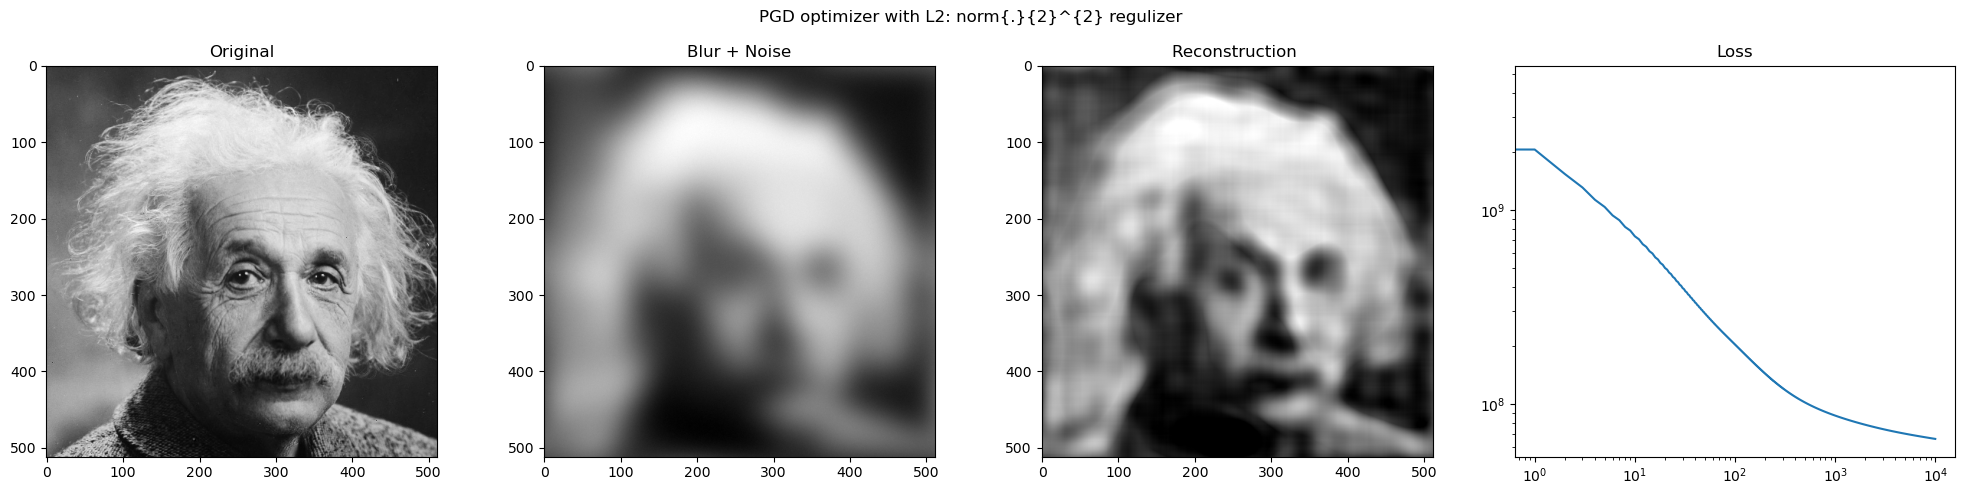

In [ ]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L2: norm{.}{2}^{2} regulizer')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

- L2: \norm{x}{2}^{2}, model 2 (with periodic padding)

In [ ]:
# initialisation 
x = jnp.zeros(img.shape) + 0.0001
y = jnp.array(per_blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
# L = jnp.max(jnp.abs(A.img_kernel_f))


# optimization parameters
alpha = 0.1 # pas prendre 1/L car on a ajouté le regulizer dans la dérivée du loss, donc c'est plus ca, mais du coup, je sais pas comment trouver alpha, --> ou sinon j utilise le prox pour le regulizer
n_iter = 5000 
# n_iter = 10 



losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha, loss_rL2) 
    losses.append(loss_val) 

100%|██████████| 5000/5000 [00:32<00:00, 152.85it/s]


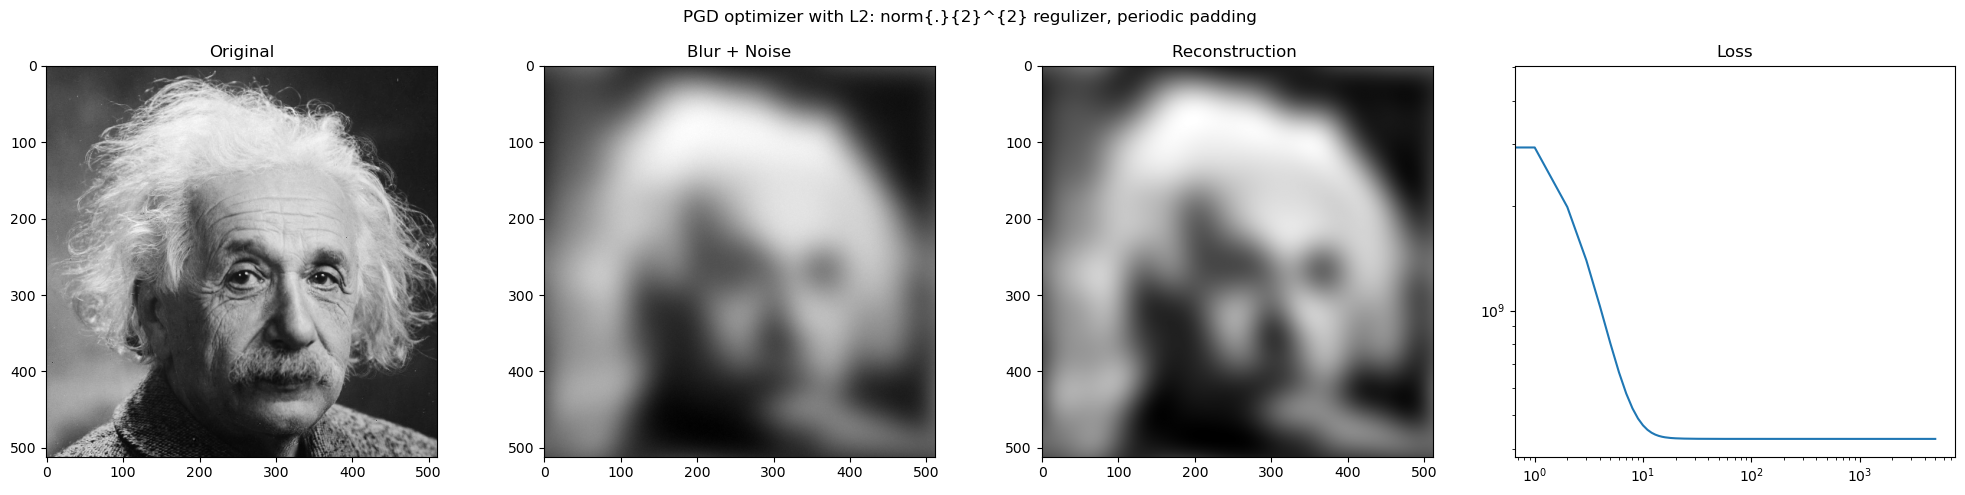

In [ ]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L2: norm{.}{2}^{2} regulizer, periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

In [14]:
# change value of the init x and number iter to compare with and without padding results.

- L1: \Norm{x}{1}, model 1: without periodic padding

In [6]:
# here g(x) = ||x||{1} is not smooth anymore. To solve inverse problem we use PGD with a proximal step
def f(x, y, A):
    fx = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return fx

def g(x):
    gx = jnp.sum(jnp.abs(x))
    return gx

# PGD opitmizer
@jax.jit
def L1_optimizer_step(x, y, A, alpha, tau):  # alpha = step size
    grads_val = jax.grad(f)(x, y, A)
    # print(grads_val)
    
    # GD update
    z = x - alpha * grads_val
    # print(z)
    # proximal step (soft threshold since is g(x) = ||x||{1})
    x_new = jnp.sign(z)*jnp.maximum(jnp.abs(z)-tau, 0.0)
    # print(x_new)

    # projection
    # x_new = jnp.clip(x_new, 0, 255)
    
    # diff objectiv value 
    Fx_new = f(x_new,y, A) + g(x_new)
    return x_new, Fx_new

In [7]:
# init
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))
# L = jnp.max(jnp.abs(A.img_kernel_f))

Fx_true = f(img, y, A) + g(img)
Fx_init = f(x, y, A) + g(x)
error = []
error.append(Fx_init-Fx_true)

# optimization parameters
alpha = 0.5
lam = 0.1
tau = alpha*lam
n_iter = 200

# # solve 
for _ in tqdm(range(n_iter)):
    x, Fx = L1_optimizer_step(x, y, A, alpha, tau) 
    error.append(Fx-Fx_true)

100%|██████████| 200/200 [08:16<00:00,  2.48s/it]


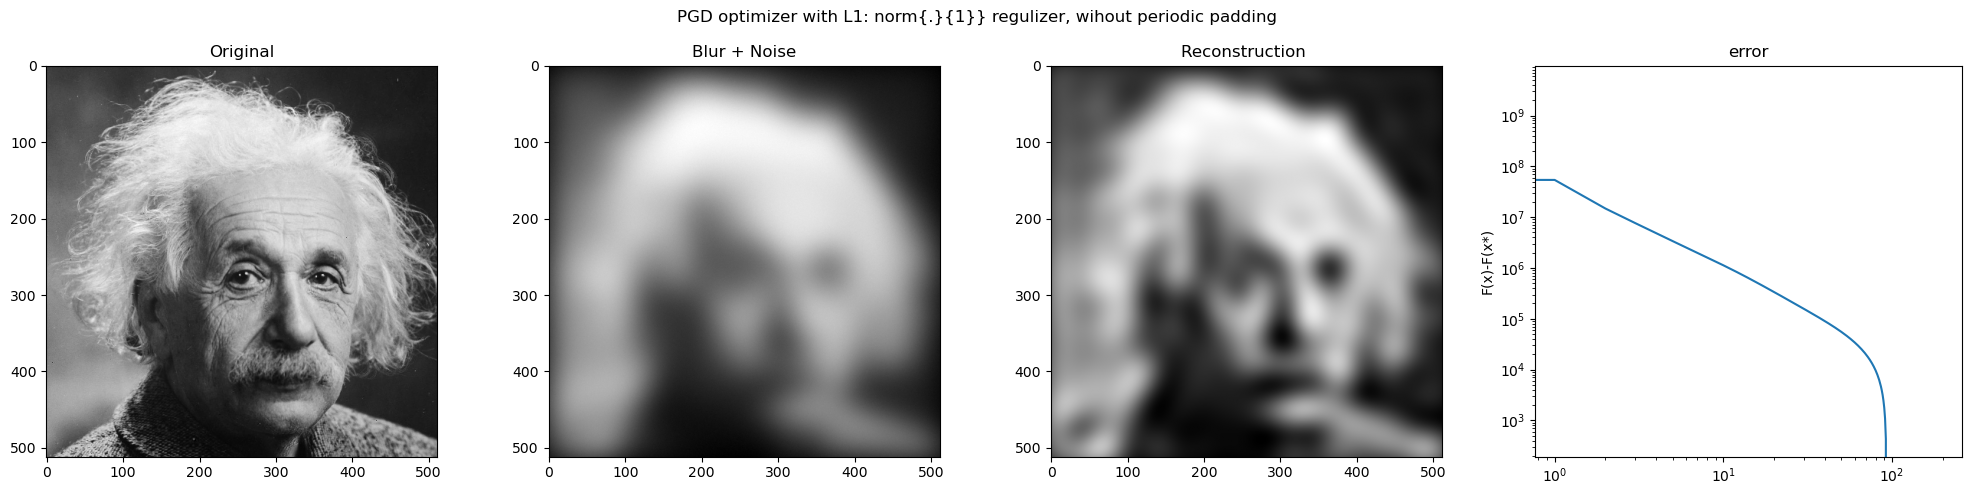

In [8]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L1: norm{.}{1}} regulizer, wihout periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(error)
ax4.set_title('error')
ax4.set_ylabel('F(x)-F(x*)')
plt.tight_layout()
plt.show()

In [15]:
# put error in absolute value ! bc error[-1] is negative ! c est pour ca qu on voit pas vraiment de convergence la

- L1: \Norm{x}{1}, model 2: with periodic padding

In [ ]:
# init
x = jnp.zeros(img.shape)
y = jnp.array(per_blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
Fx_true = f(img, y, A) + g(img)
Fx_init = f(x, y, A) + g(x)
error = []
error.append(Fx_init-Fx_true)

# optimization parameters
L = jnp.max(jnp.abs(A.img_kernel_f))
alpha = 1/L
lam = 0.1
tau = alpha*lam
n_iter = 20000

# solve 
for _ in tqdm(range(n_iter)):
    x, Fx = L1_optimizer_step(x, y, A, alpha, tau) 
    error.append(Fx-Fx_true)

100%|██████████| 20000/20000 [07:05<00:00, 46.95it/s]


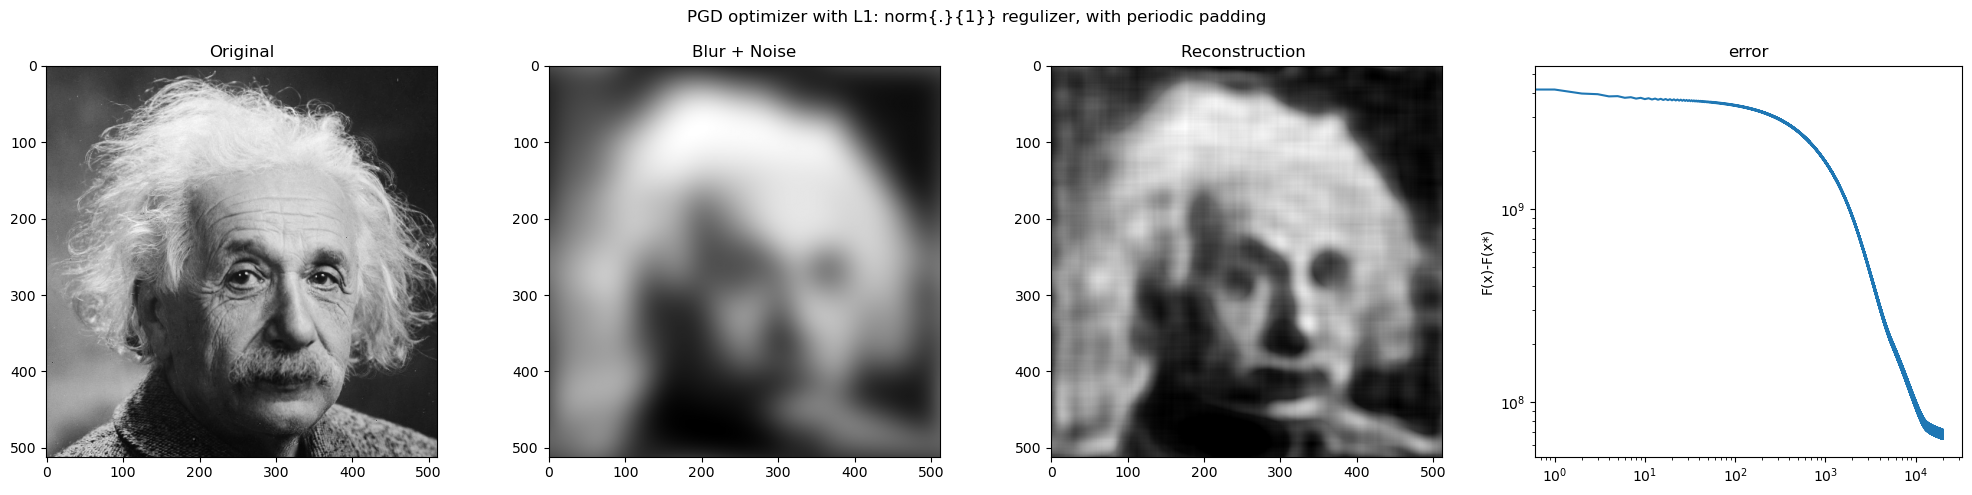

In [ ]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L1: norm{.}{1}} regulizer, with periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(error)
ax4.set_title('error') # try to plot loss instead, and try to remove the noise to see if we achieved better result...
ax4.set_ylabel('F(x)-F(x*)')
plt.tight_layout()
plt.show()

- TV: \Norm{L.}{1}, model 2: with periodic padding

In [4]:
# here g(x) = ||grad(x)||{1} is not smooth. To solve inverse problem we use PGD with a proximal step

# loss function 
def f(x, y, A):
    fx = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return fx

# def g(x): 
#     # use forward difference to compute grad_x and grad_y 
#     grad_x = jnp.roll(x, -1, axis=1) - x
#     grad_x = grad_x.at[:,-1].set(0) # (due to forward differences approx)

#     grad_y = jnp.roll(x, -1, axis=0) - x
#     grad_y = grad_y.at[-1].set(0) # (due to forward differences approx)

#     return gx

# @jax.jit
def TV_L1_optimizer_step(x, y, A, alpha, lam):  # alpha = step size
    grads_val = jax.grad(f)(x, y, A)
    # print(grads_val)
    
    # GD update
    z = x - alpha * grads_val

    # proximal step 
    x_new = ski.restoration.denoise_tv_chambolle(z, weight=lam)
    # print(type(x_new))

    # projection
    # x_new = jnp.clip(x_new, 0, 255)
    
    # objectiv value 
    # Fx_new = f(x_new,y, A) + g(x_new)
    # return x_new, Fx_new
    return x_new 

In [5]:
# init
x = jnp.zeros(img.shape)
y = jnp.array(per_blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
# Fx_true = f(img, y, A) + g(img)
# Fx_init = f(x, y, A) + g(x)
# error = []
# error.append(Fx_init-Fx_true)

# optimization parameters
L = jnp.max(jnp.abs(A.img_kernel_f))
alpha = 1/L
lam = 0.1
n_iter = 4000

# solve 
for _ in tqdm(range(n_iter)):
    # x, Fx = L1_optimizer_step(x, y, A, alpha, tau) 
    x = TV_L1_optimizer_step(x, y, A, alpha, lam) 

    # error.append(Fx-Fx_true)

100%|██████████| 4000/4000 [01:24<00:00, 47.44it/s]


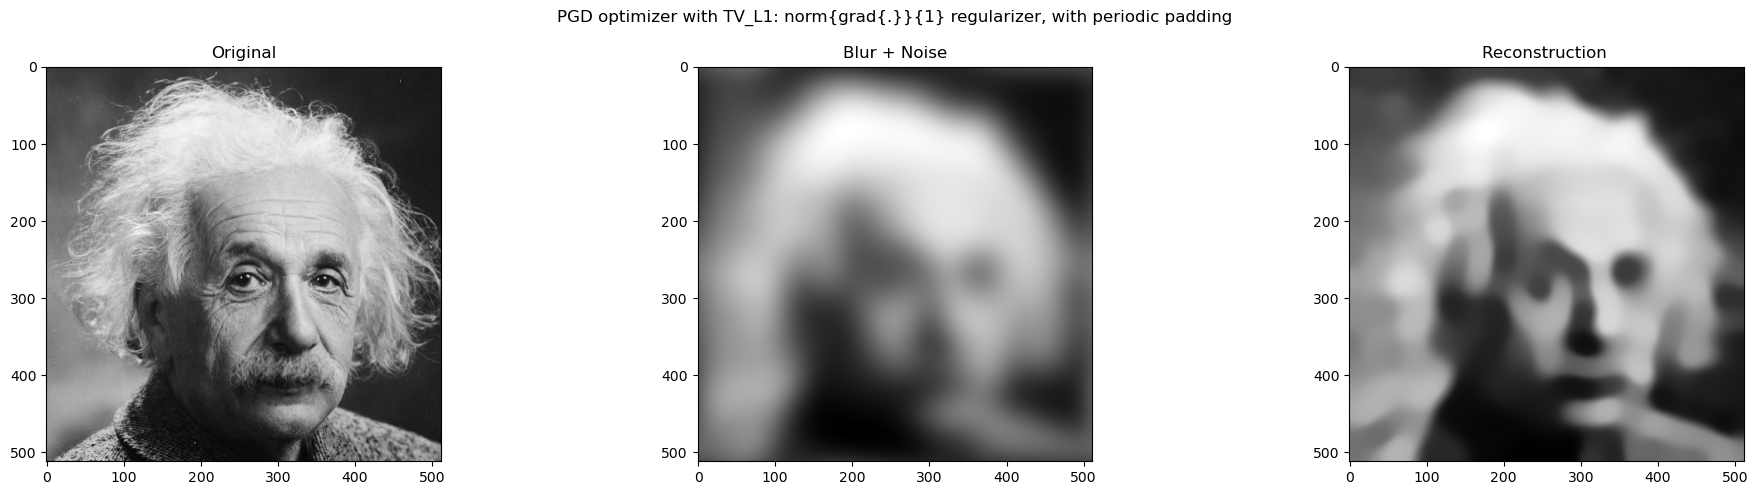

In [13]:
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(20,5))
fig.suptitle('PGD optimizer with TV_L1: norm{grad{.}}{1} regularizer, with periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
# ax4.loglog(error)
# ax4.set_title('error')
# ax4.set_ylabel('F(x)-F(x*)')
plt.tight_layout()
plt.show()

In [ ]:
# test avec TV
# regarder si on a bien ISTA avec TV ---> dans le cours de MOD et sur google
# chercher une méthode qui me compute le total variation car j ai pas d'expression analytique (ex. skimage.restoration.chandeller)
# tester les deux implémentation si je ne trouve pas
# avec l1 norm x --> closed form --> simple tresholding


In [ ]:
# alpha : step size = 1/L (si j'arrive à trouver L) --> pourrait se trouver en prenant transfo de fourrier du kernel puis prendre le max
# lambda : facteur amplifiant la sparsité dans le cas {norm_l1} comme regulizer
# tau : threshold = alpha*lambda 

# faire ca, pour L--> regarder slide img proc 1 dernier chap

#chnager l1 -->ajouter en parametre lambda pour prendre en compte le facteur d intensité et le treshold 

In [ ]:
test =jnp.array([[1,2,3,4],[2,3,48,5], [23,5,1,6]])
print(test)
print(jnp.roll(test, -1, axis=1))
test2 =jnp.roll(test, -1, axis=0) - test
print(test2)
test2 = test2.at[-1].set(0)
print(test2)